In [ ]:
##before Seurat process on linux server##
##genrate fastq from bcl file 
cellranger mkfastq
##align fastq to the expression matrix
cellranger count
##multi-sample Aggregation
cellranger aggr
##Web_summary.html
##Display

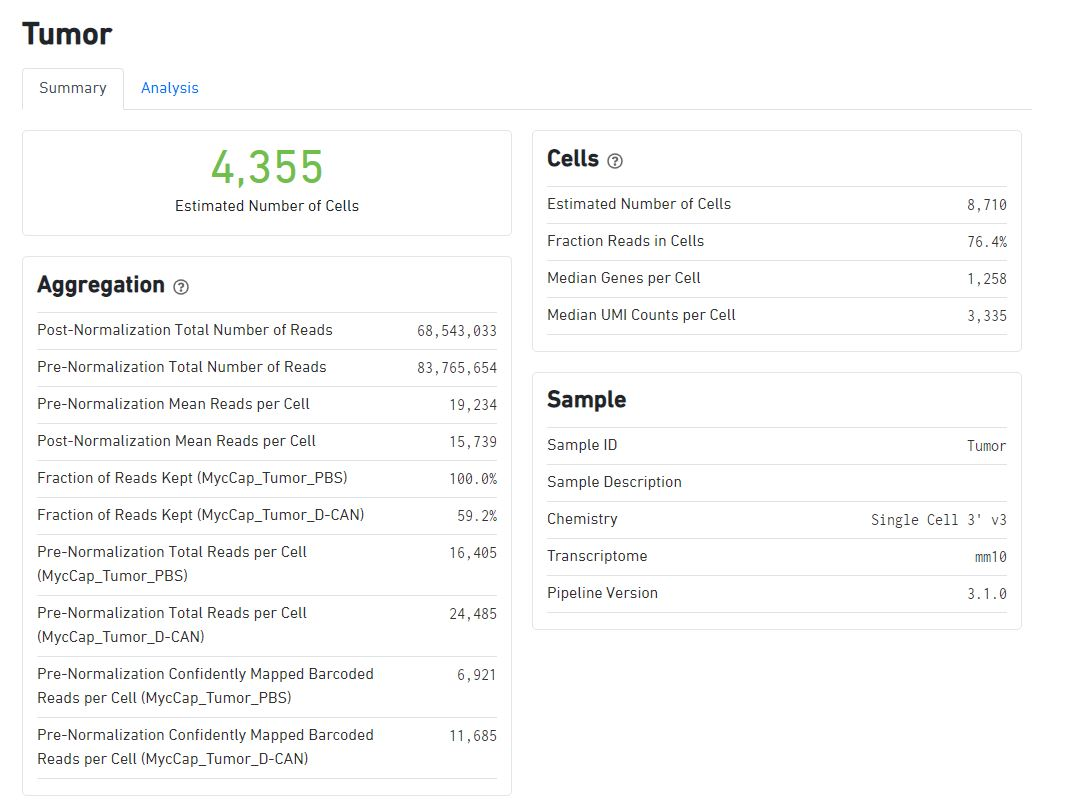
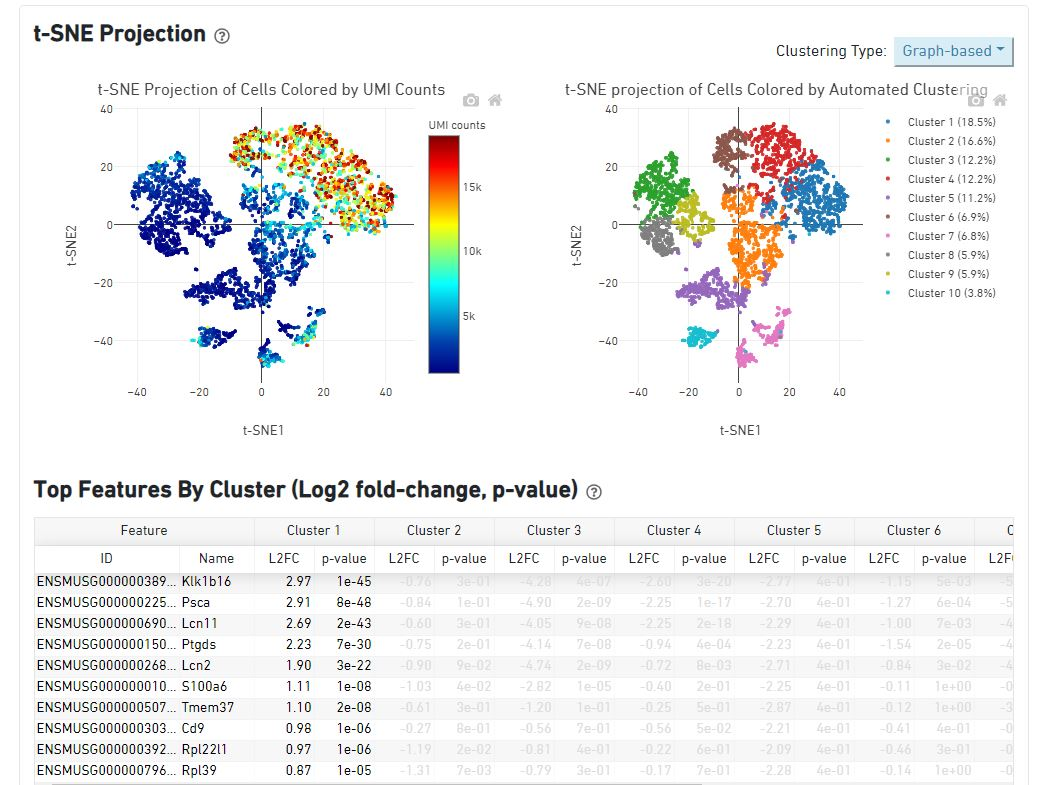

In [16]:
##install Seurat by install.packages("Seurat")
##then install tSNE/UMAP
##https://satijalab.org/seurat/v3.0/mca.html
##https://satijalab.org/seurat/v3.0/cell_cycle_vignette.html
##https://satijalab.org/seurat/v3.0/pbmc3k_tutorial.html
##https://satijalab.org/seurat/v3.0/sctransform_vignette.html
##https://satijalab.org/seurat/v3.0/cell_cycle_vignette.html
##https://satijalab.org/seurat/v3.0/immune_alignment.html
##This pipeline is run on 3.5.3, but should work on higher version of R
library(dplyr)
library(ggplot2)
library(sctransform)
library(monocle)
library(ComplexHeatmap)
library(circlize)
library("hdf5r")
library(Seurat)
library(Hmisc)

In [74]:
options(warn=-1)
##Regress cell-cycle heterogneity##
s.genes <- read.delim("C:\\Users\\ydai2\\Dropbox\\19_sc_project\\cell_cycle_vignette_files\\G1.S.txt",head=F,as.is=1)
g2m.genes <- read.delim("C:\\Users\\ydai2\\Dropbox\\19_sc_project\\cell_cycle_vignette_files\\G2.M.txt",head=F,as.is=1)
s.genes <- s.genes[,1]
g2m.genes <- g2m.genes[,1]

In [17]:
##mouse gene
s.genes

[1] "Mcm5"     "Pcna"     "Tyms"     "Fen1"     "Mcm2"     "Mcm4"    
 [7] "Rrm1"     "Ung"      "Gins2"    "Mcm6"     "Cdca7"    "Dtl"     
[13] "Prim1"    "Uhrf1"    "Mlf1ip"   "Hells"    "Rfc2"     "Rpa2"    
[19] "Nasp"     "Rad51ap1" "Gmnn"     "Wdr76"    "Slbp"     "Ccne2"   
[25] "Ubr7"     "Pold3"    "Msh2"     "Atad2"    "Rad51"    "Rrm2"    
[31] "Cdc45"    "Cdc6"     "Exo1"     "Tipin"    "Dscc1"    "Blm"     
[37] "Casp8ap2" "Usp1"     "Clspn"    "Pola1"    "Chaf1b"   "Brip1"   
[43] "E2f8"

In [24]:
input_path <- ("C:\\work in uth\\collaboration\\for CGC\\3.Kolonin_4.10.2020\\sc_data\\updated_mouse_only\\2.merged_1\\1.SAT\\outs\\filtered_feature_bc_matrix.h5")
input_data <- Read10X_h5(input_path)
dense.size <- object.size(x = as.matrix(x = input_data))
sparse.size <- object.size(x = input_data)
##Examine the memory savings between regular and sparse matrices
print(dense.size)
print(sparse.size)
dense.size/sparse.size

1188174024 bytes
53517640 bytes


22.2 bytes

In [41]:
# Initialize the Seurat object with the raw (non-normalized data).  Keep all
# genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at
# least 200 detected genes
input <- CreateSeuratObject(counts = input_data,min.cells = 3)

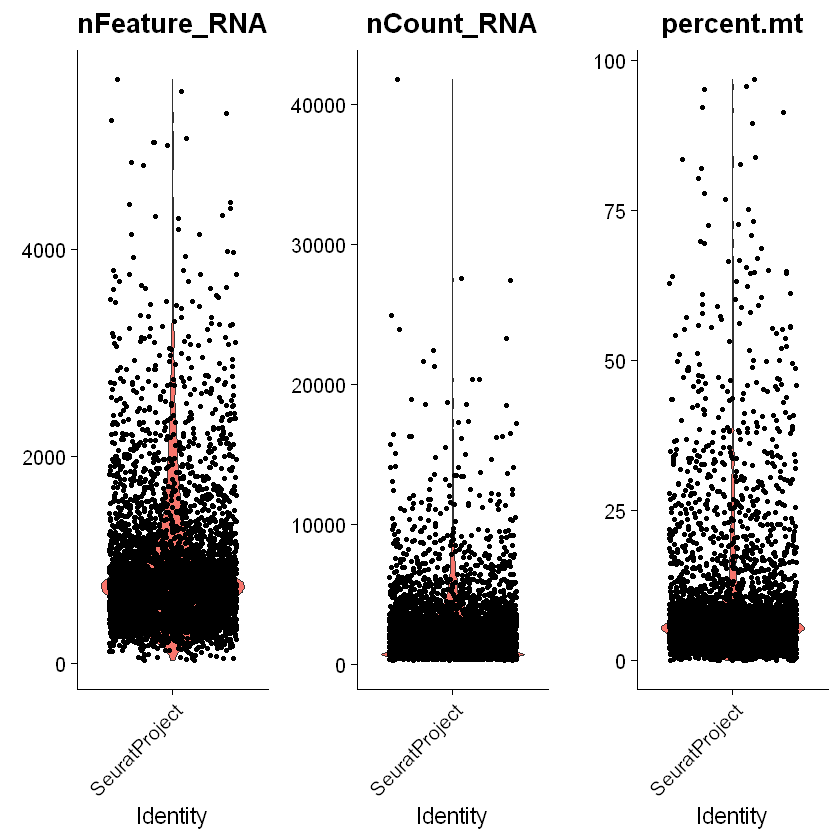

In [39]:
##QC and selecting cells for further analysis
input[["percent.mt"]] <- PercentageFeatureSet(object = input, pattern = "^mt-")
##before QC filter
setwd("C:\\work in uth\\collaboration\\for CGC\\3.Kolonin_4.10.2020\\2.result\\1.SAT_unfiltered\\")
VlnPlot(object = input, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


In [40]:
##only keep mitochondrial <= 10, nCount_RNA <= 10000,  nFeature_RNA > 200  ) 
##However sometimes, it does not need to filter so much.
input_filtered <- subset(x = input, subset = percent.mt <= 10 & nCount_RNA <= 10000 & nFeature_RNA > 200)

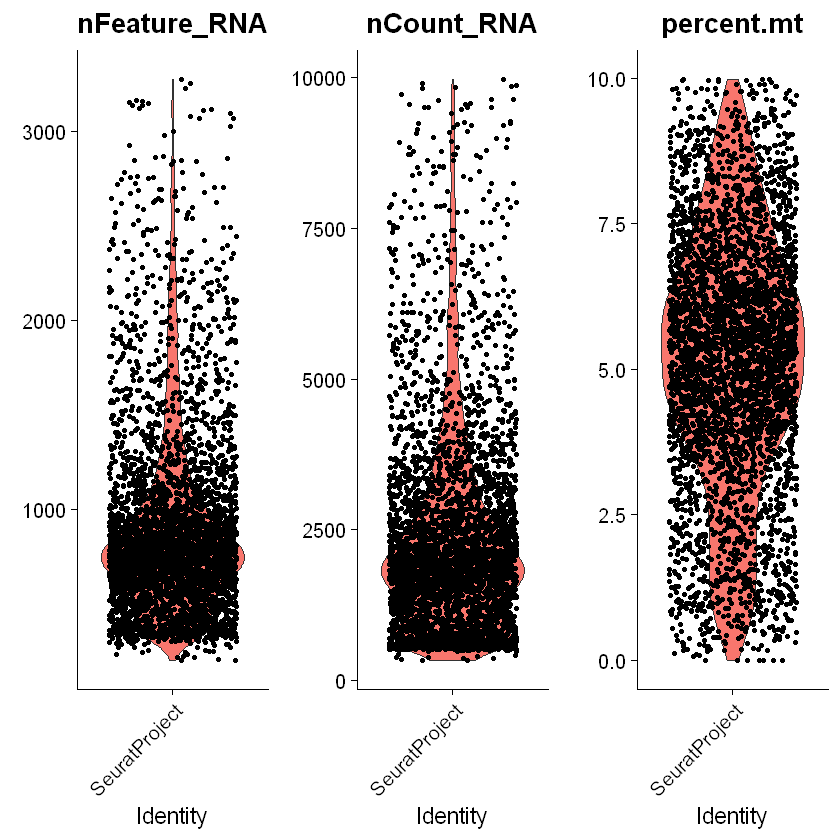

In [27]:
VlnPlot(object = input_filtered, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [43]:
##label the cells##
label_sim <- rep("DCAN", length(input_filtered$orig.ident))
label_sim[grep("-2",names(input_filtered$orig.ident))] <- "PBS"
input_filtered$sample.indent <- label_sim

In [75]:
##without any regression##
input_filtered <- SCTransform(object = input_filtered,verbose = FALSE)
input_filtered <- RunPCA(object = input_filtered, ndims.print = 1:20,verbose = FALSE)

In [ ]:
##regress mitochondrial##
mito.genes <-rownames(input_filtered)[grep("^mt-",rownames(input_filtered))]
input_filtered[["percent.mt"]] <- PercentageFeatureSet(object = input_filtered, pattern = "^mt-")
input_filtered <- SCTransform(object = input_filtered,vars.to.regress = "percent.mt",verbose = FALSE)
input_filtered <- RunPCA(object = input_filtered,ndims.print = 1:20,verbose = FALSE)

In [46]:
##get cell cycle genes scores from data##
input_filtered <- CellCycleScoring(object = input_filtered, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
input_filtered <- RunPCA(object = input_filtered, ndims.print = 1:20, nfeatures.print = 10)

Warning message:
"The following features are not present in the object: Mlf1ip, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: Fam64a, Hn1, not searching for symbol synonyms"
PC_ 1 
Positive:  Fabp4, Sparc, Igfbp7, Cd36, Ifitm3, Mgll, Rbp7, Ly6c1, Hspb1, Cav1 
Negative:  Cd74, Igkc, H2-Ab1, Rps24, Rpsa, H2-Aa, Rpl12, Rps27, Cd52, Rps19 
PC_ 2 
Positive:  Fabp4, Cd36, Rbp7, Mgll, Gpihbp1, Cavin2, Cav1, Cldn5, Cdh5, Fabp5 
Negative:  Dcn, Col3a1, Gsn, Col1a2, Col1a1, Serping1, S100a6, Clec3b, Igfbp6, Aebp1 
PC_ 3 
Positive:  Trbc2, Trbc1, Cd3g, Cd3d, Ccl5, Cd28, Trac, Nkg7, Emb, Cd3e 
Negative:  Cd74, Igkc, H2-Ab1, H2-Aa, Ly6d, Cd79a, Iglc2, Ighd, Ebf1, Ighm 
PC_ 4 
Positive:  Gpihbp1, Mgll, Igkc, Rpl12, Rps24, Ly6c1, Cd36, Rplp1, Dcn, Rbp7 
Negative:  Tyrobp, Fcer1g, S100a4, Lyz2, Cst3, Tmem176a, Ftl1, Tmem176b, Ccl5, Vim 
PC_ 5 
Positive:  Tyrobp, Fcer1g, Ccl5, Lyz2, Gpihbp1, Mgll, Fabp5, Tmsb4x, Cd36, Ftl1 
Negative:  Tagln, 

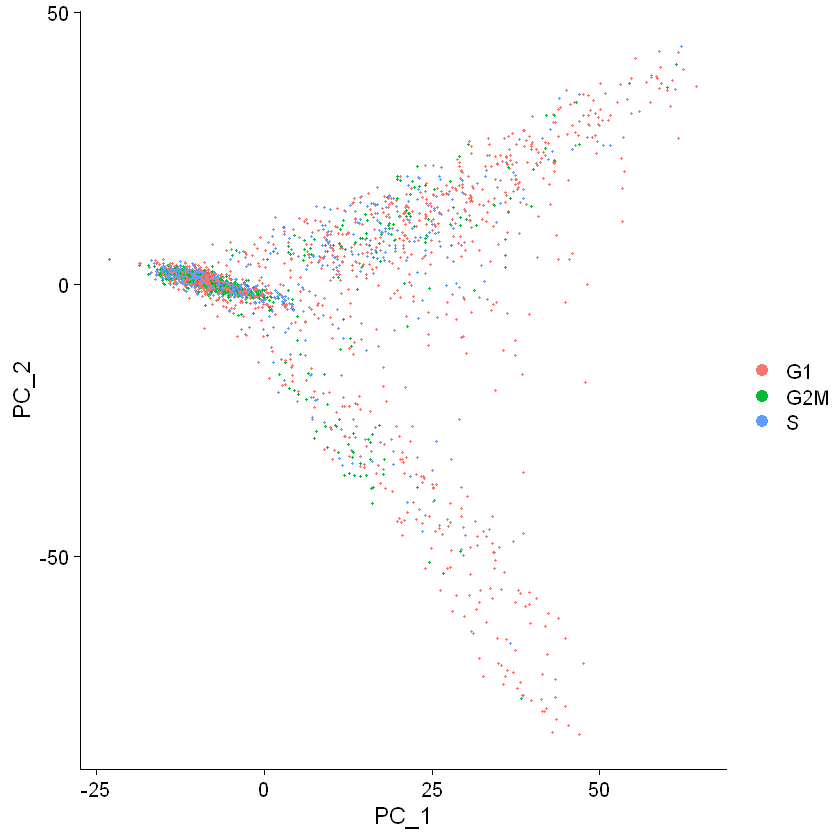

In [47]:
DimPlot(object = input_filtered)

In [ ]:
##regress the percent.mt, S.Score, G2M.Score from a new input file
##to be notified, sometimes they
input_regressed <- CreateSeuratObject(counts = input_data,min.cells = 3)
input_regressed[["percent.mt"]] <- PercentageFeatureSet(object = input_regressed, pattern = "^mt-")
input_regressed <- subset(x = input_regressed, subset = percent.mt <= 10 & nCount_RNA <= 10000 & nFeature_RNA > 200  )
input_regressed$sample.indent <- input_filtered$sample.indent
input_regressed$S.Score <- input_filtered$S.Score
input_regressed$G2M.Score <- input_filtered$G2M.Score
input_regressed$Phase <- input_filtered$Phase
input_regressed@active.ident <- input_filtered@active.ident

label_sim <- rep("DCAN", length(input_filtered$orig.ident))
label_sim[grep("-2",names(input_filtered$orig.ident))] <- "PBS"
input_filtered$sample.indent <- label_sim
input_regressed <- SCTransform(object = input_regressed, vars.to.regress = c("percent.mt","S.Score", "G2M.Score"), verbose = FALSE)

In [49]:
##We won't see the cell cycle gene and mt-gene in the PC top 10 genes
input_regressed <- RunPCA(object = input_regressed,ndims.print = 1:20, nfeatures.print = 10)

PC_ 1 
Positive:  Fabp4, Sparc, Cd36, Igfbp7, Mgll, Ifitm3, Rbp7, Hspb1, Ly6c1, Cav1 
Negative:  Cd74, Igkc, H2-Ab1, H2-Aa, Rps24, Rpl12, Rpsa, Rps27, Cd52, Rps19 
PC_ 2 
Positive:  Fabp4, Cd36, Rbp7, Mgll, Gpihbp1, Cavin2, Cav1, Cldn5, Cdh5, Fabp5 
Negative:  Dcn, Gsn, Col3a1, Col1a2, Col1a1, Serping1, S100a6, Clec3b, Igfbp6, Aebp1 
PC_ 3 
Positive:  Trbc2, Trbc1, Cd3g, Cd3d, Ccl5, Cd28, Trac, Nkg7, Emb, Cd3e 
Negative:  Cd74, Igkc, H2-Ab1, H2-Aa, Ly6d, Cd79a, Iglc2, Ebf1, Ighm, Ighd 
PC_ 4 
Positive:  Gpihbp1, Mgll, Cd36, Ly6c1, Rpl12, Rps24, Dcn, Rbp7, Btnl9, Rplp1 
Negative:  Tyrobp, Fcer1g, S100a4, Cst3, Lyz2, Tmem176a, Tagln, Ftl1, Tmem176b, Igfbp7 
PC_ 5 
Positive:  Tagln, Igfbp7, Acta2, Rgs5, Tpm2, Myh11, Myl9, Sparcl1, Notch3, Cald1 
Negative:  Tyrobp, Fcer1g, Lyz2, Ccl5, Ftl1, Tmsb4x, Psap, Fabp5, Marcks, Epsti1 
PC_ 6 
Positive:  Ccl5, Fscn1, Epsti1, Basp1, H2-M2, Tmem123, Cacnb3, Tbc1d4, Lsp1, Serpinb6b 
Negative:  Lrg1, Plvap, Ifitm3, Ehd4, Lyz2, Apoe, Wfdc17, Ier3, Aqp1, 

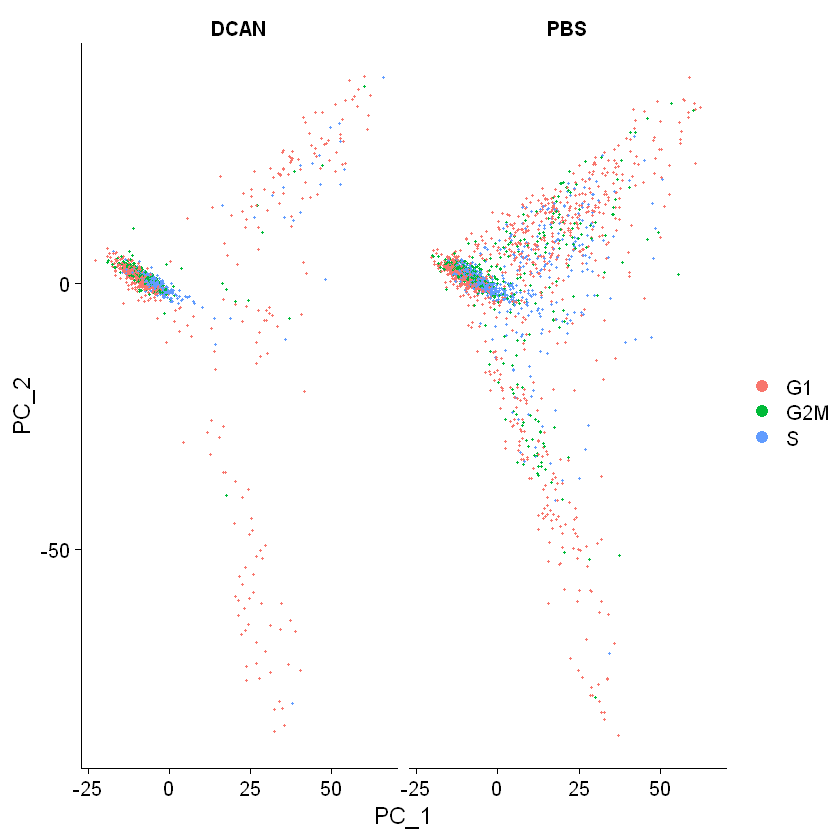

In [50]:
DimPlot(object = input_regressed,split.by = "sample.indent")
##After regression, the G1,G2M,S cell types merged together.

In [53]:
##Find Clusters
input_regressed <- FindNeighbors(object = input_regressed, dims = 1:20, verbose = FALSE)
##most important setting is resolution, which were normally set to 0.6-1.0, but could vary under different demand.
input_regressed <- FindClusters(object = input_regressed, verbose = FALSE, resolution = 0.6 )

In [54]:
#Run non-linear dimensional reduction (UMAP/tSNE) to demonstrate the PCs.
input_regressed <- RunTSNE(object = input_regressed, dims = 1:20, tsne.method = "Rtsne", nthreads = 4, max_iter = 2000, reduction.name = "tSNE")
input_regressed <- RunUMAP(object = input_regressed, dims = 1:20, min.dist = 0.75,reduction.name = "UMAP")

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
02:04:25 UMAP embedding parameters a = 0.2734 b = 1.622

02:04:25 Read 3874 rows and found 20 numeric columns

02:04:25 Using Annoy for neighbor search, n_neighbors = 30

02:04:25 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

02:04:26 Writing NN index file to temp file C:\Users\ydai2\AppData\Local\Temp\RtmpeaCHVp\file557c228d6a9a

02:04:26 Searching Annoy index using 1 thread, search_k = 3000

02:04:28 Annoy recall = 100%

02:04:28 Commencing smooth kNN distance calibration using 1 thr

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


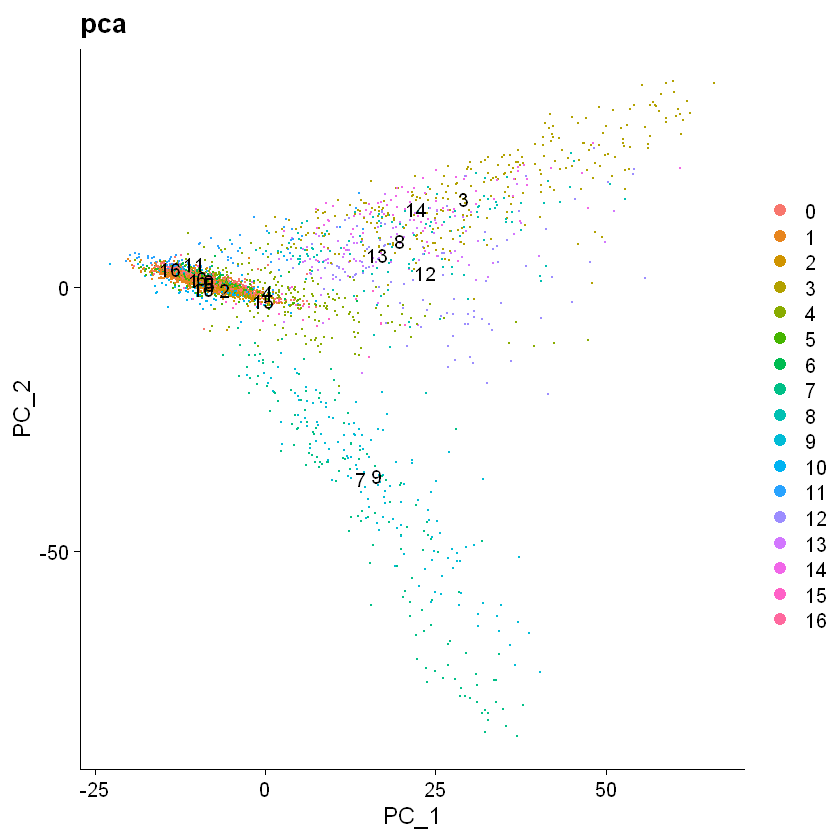

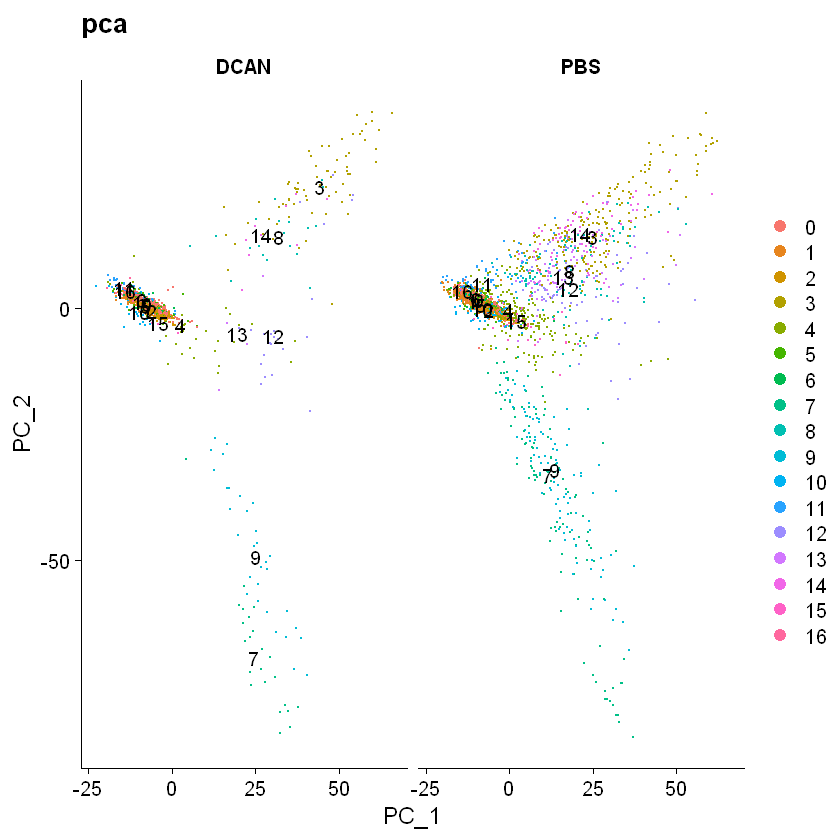

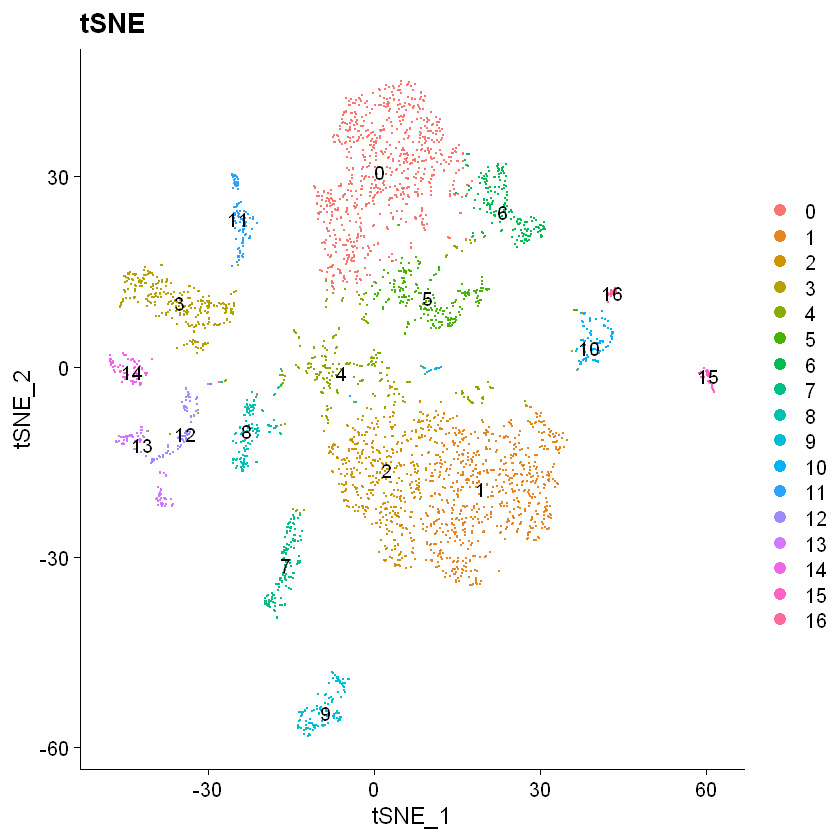

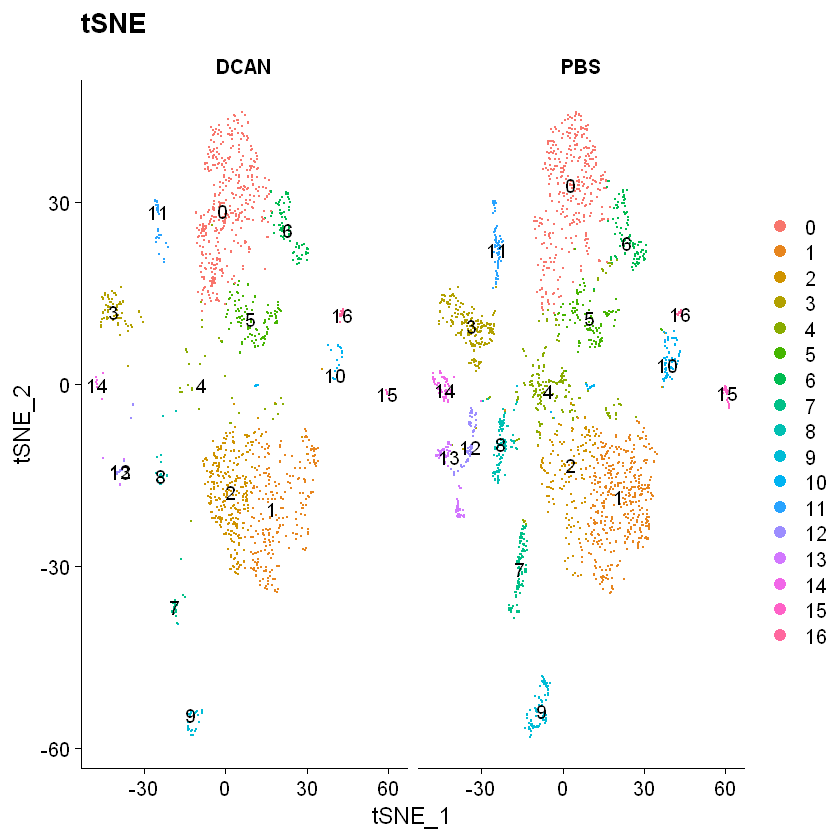

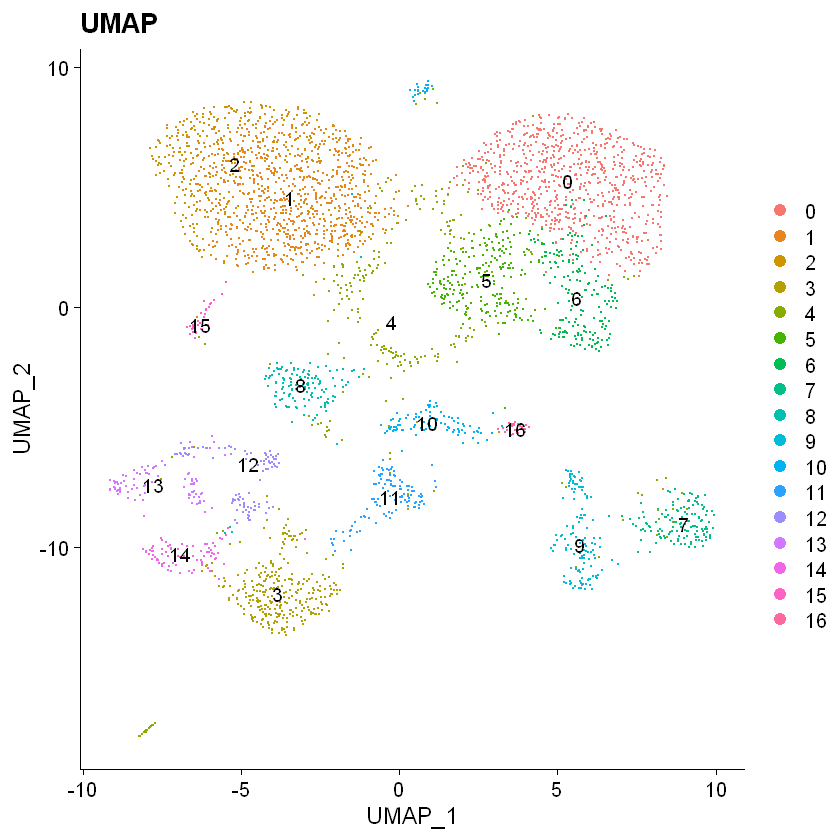

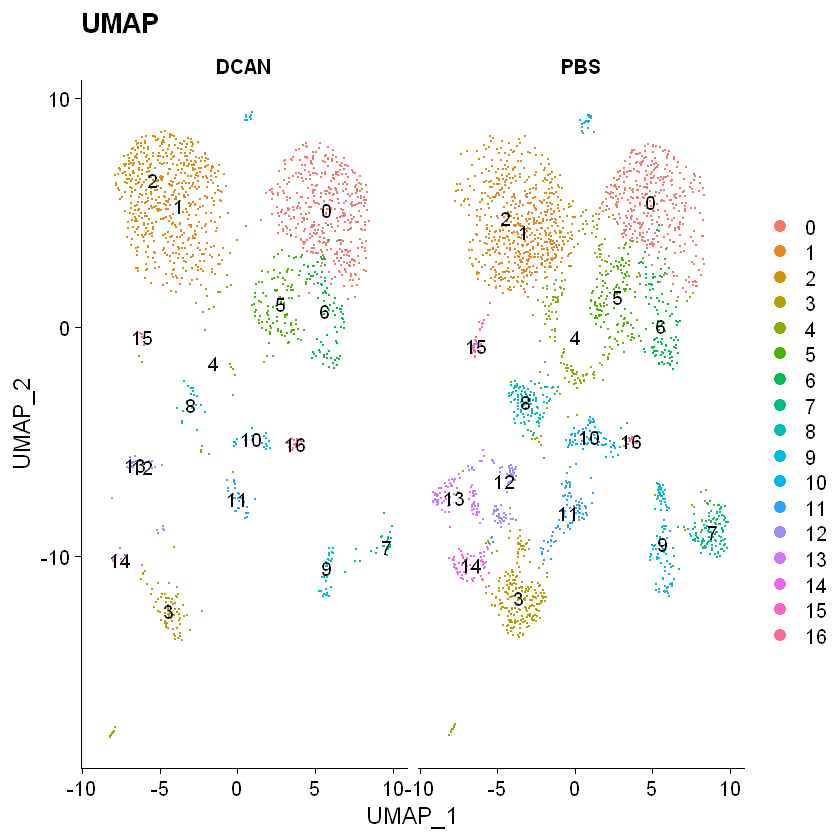

In [56]:
##PCA
DimPlot(object = input_regressed, label = TRUE,reduction = "pca", pt.size = 0.3) + ggtitle(label = "pca")
DimPlot(object = input_regressed, label = TRUE,reduction = "pca", pt.size = 0.3,split.by = "sample.indent") + ggtitle(label = "pca")
##tSNE
DimPlot(object = input_regressed, label = TRUE,reduction = "tSNE", pt.size = 0.3) + ggtitle(label = "tSNE")
DimPlot(object = input_regressed, label = TRUE,reduction = "tSNE",pt.size = 0.3,split.by = "sample.indent") + ggtitle(label = "tSNE")
##UMAP
DimPlot(object = input_regressed, label = TRUE,reduction = "UMAP", pt.size = 0.3) + ggtitle(label = "UMAP")
DimPlot(object = input_regressed, label = TRUE,reduction = "UMAP", pt.size = 0.3,split.by = "sample.indent") + ggtitle(label = "UMAP")

In [55]:
##generate the cell proportion difference between DCAN and PBS
cell_prop <- prop.table(x = table(Idents(object = input_regressed),input_regressed$sample.indent),margin =2)
cell_prop <- round(cell_prop,3)
print(cell_prop)

    
      DCAN   PBS
  0  0.282 0.150
  1  0.178 0.184
  2  0.205 0.064
  3  0.048 0.089
  4  0.028 0.099
  5  0.074 0.051
  6  0.056 0.043
  7  0.016 0.048
  8  0.013 0.048
  9  0.021 0.042
  10 0.020 0.036
  11 0.020 0.034
  12 0.016 0.031
  13 0.003 0.036
  14 0.006 0.030
  15 0.003 0.013
  16 0.011 0.005


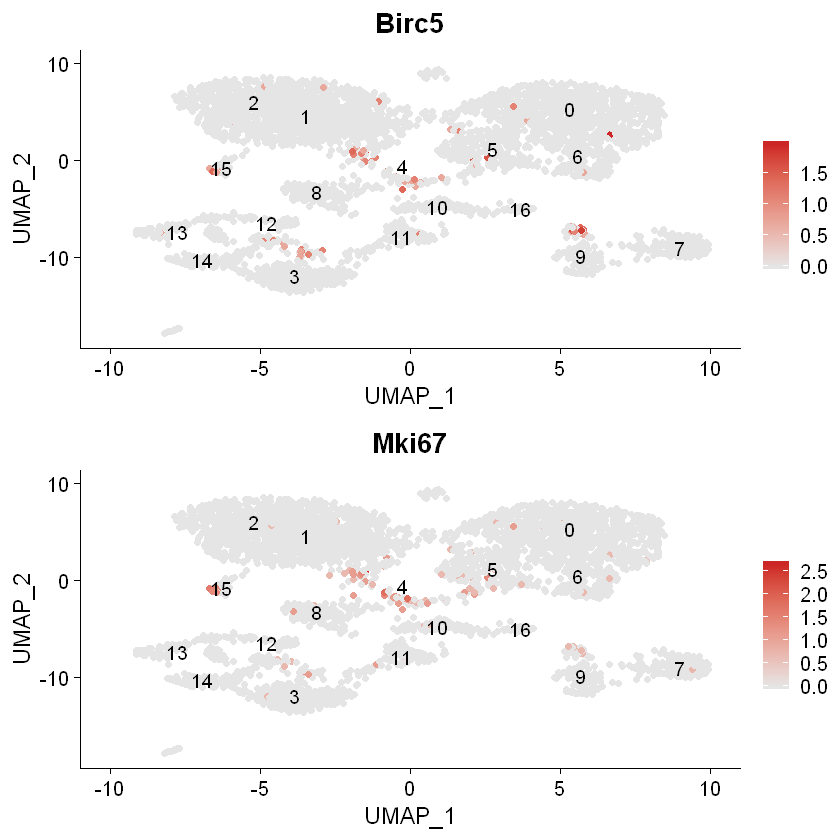

In [59]:
##gene expression in clusters in UMAP
FeaturePlot(object = input_regressed, features = c("Birc5","Mki67"),cols = c("grey90", "firebrick3"),ncol=1,label = TRUE,pt.size=1.5)

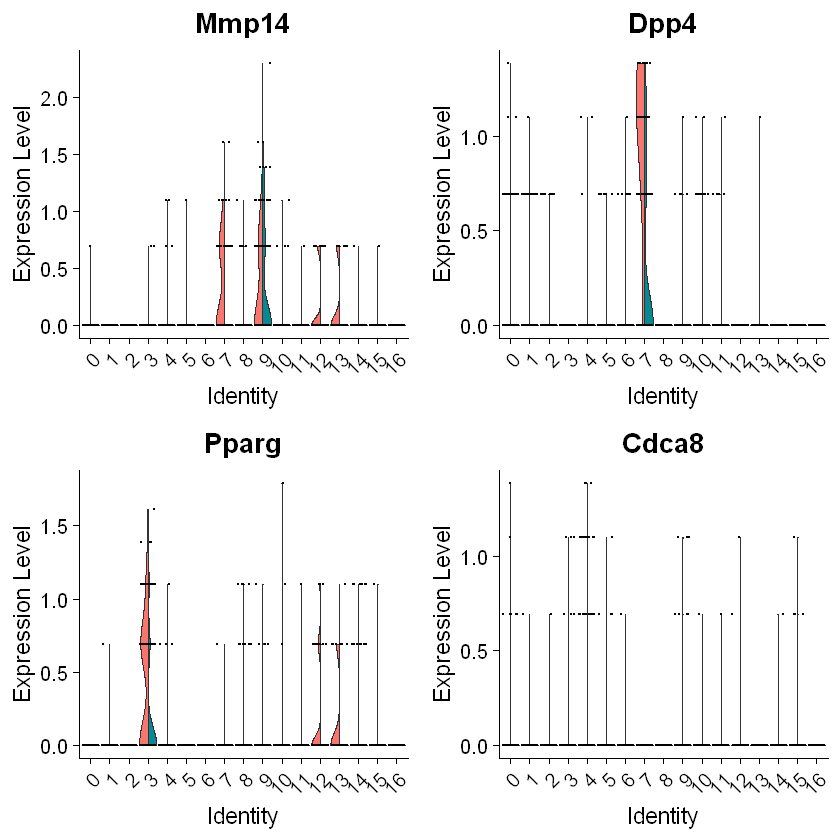

In [60]:
##vioplot to show the gene expression difference between groups
VlnPlot(object = input_regressed, features = c("Mmp14","Dpp4","Pparg","Cdca8"), pt.size = 0.2, ncol = 2,split.by = "sample.indent")

Warning message:
"Removed 58 rows containing missing values (geom_point)."


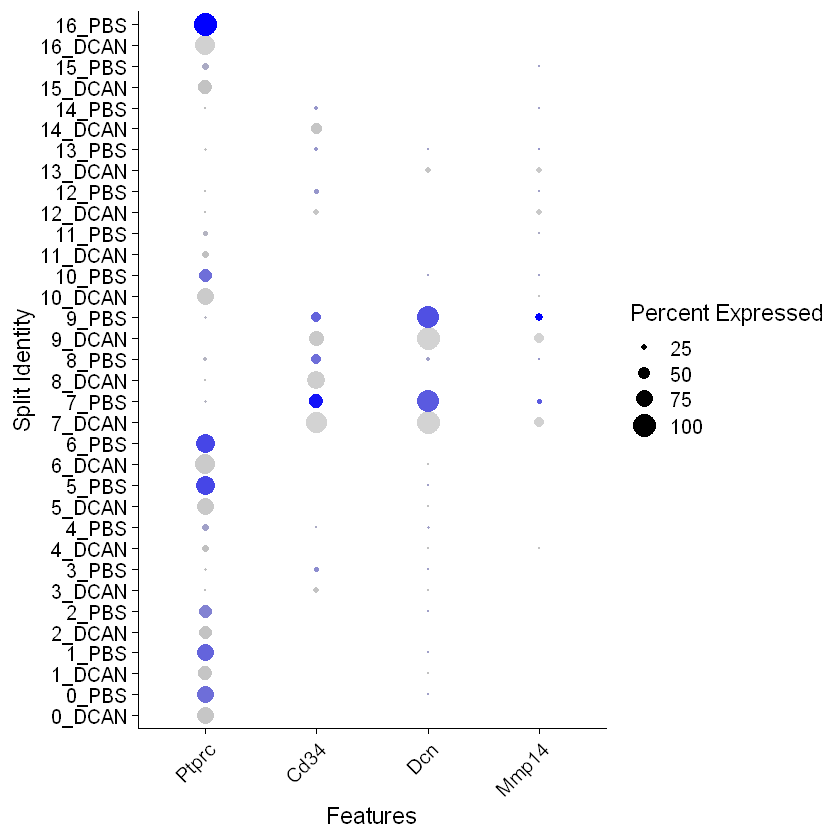

In [61]:
##Dotplot also used to use the gene expression difference between groups
DotPlot(object = input_regressed, features = c("Mmp14","Dcn","Cd34","Ptprc"),dot.min = 0.01,split.by = "sample.indent") + RotatedAxis()

In [62]:
##Find cluster marker genes.
Idents(object = input_regressed)<- input_regressed$SCT_snn_res.0.6
input_regressed.markers <- FindAllMarkers(object = input_regressed, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
input_regressed.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC) -> markers
markers.frame <- data.frame(markers)
##reorder the result##
markers.frame <- markers.frame[order(markers.frame[,6],markers.frame[,2],decreasing =T),]
markers <- markers.frame[order(markers.frame[,6]),]

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16



In [72]:
head(markers)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,0.000000e+00,1.0173257,0.921,0.168,0.000000e+00,0,Trbc2
3,7.569514e-266,0.7460787,1.000,0.976,1.069042e-261,0,Rpl12
2,2.007537e-275,0.7286473,1.000,0.995,2.835245e-271,0,Rplp1
6,2.626724e-291,1.3558560,0.999,0.473,3.709722e-287,1,Cd74
4,0.000000e+00,1.1687490,0.999,0.393,0.000000e+00,1,Igkc
5,0.000000e+00,1.1615801,0.990,0.265,0.000000e+00,1,H2-Aa


In [63]:
##get counts data
heatmap_matrix <- GetAssayData(object = input_regressed, slot = "counts")
##get normalized data
heatmap_matrix_normalized <- GetAssayData(object = input_regressed, slot = "data")

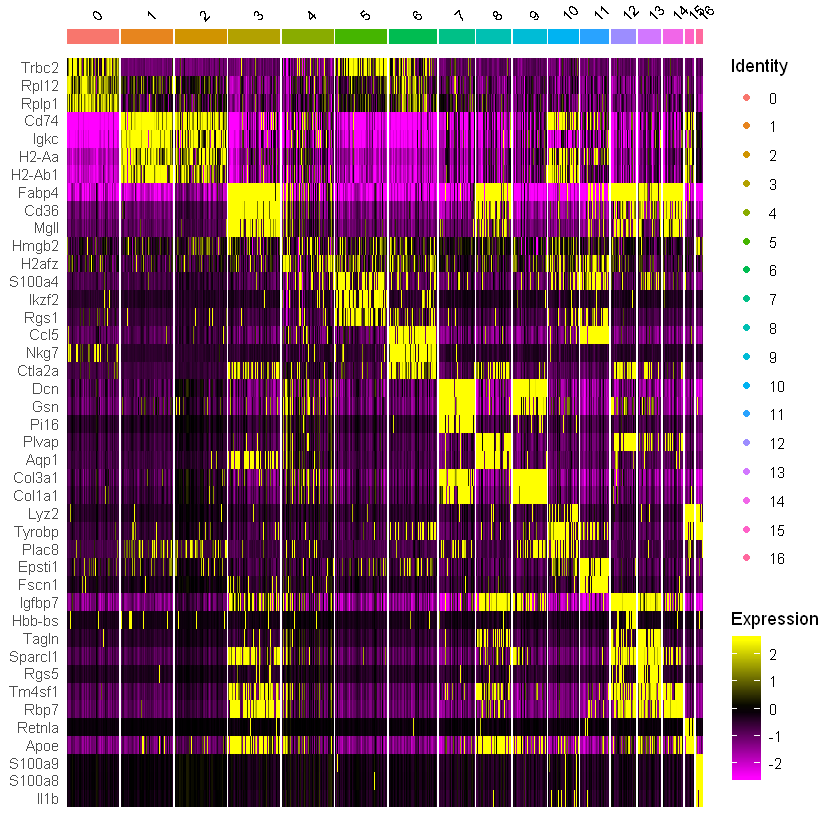

In [65]:
#####heatmap#####
##plot top 3 DEG in each clusters###
input_regressed.markers %>% group_by(cluster) %>% top_n(n = 3, wt = avg_logFC) -> markers
markers.frame <- data.frame(markers)
##reorder the result##
markers.frame <- markers.frame[order(markers.frame[,6],markers.frame[,2],decreasing =T),]
markers <- markers.frame[order(markers.frame[,6]),]
all_markers_need <- unique(markers[,7])
DoHeatmap(subset(input_regressed, downsample = 200),features = all_markers_need, size = 3)

In [66]:
##some useful commands
##load the coordinates of UAMP or tSNE
UMAP_score_1 <- input_regressed@reductions$UMAP@cell.embeddings[,1]
UMAP_score_2 <- input_regressed@reductions$UMAP@cell.embeddings[,2]

In [67]:
##pick cells from one cluster, WhichCells
cluster3 <- WhichCells(input_regressed,idents = 3)
head(cluster3)

[1] "AACCTGACATACCATG-1" "AAGCGTTGTAGTGCGA-1" "ACAACCACATGCGTGC-1"
[4] "ACAGAAACATGTGCTA-1" "ACAGAAATCATGAAAG-1" "ACCAAACAGTAGGTTA-1"

In [68]:
##rename cluster name
input_regressed_renamed <- input_regressed
input_regressed_renamed <- SetIdent(input_regressed_renamed,cells = cluster3, value = "3" )
###further merge names###
input_regressed_renamed$renames <- input_regressed_renamed@active.ident
input_regressed_renamed_merged <- input_regressed_renamed
input_regressed_renamed_merged <- RenameIdents(object = input_regressed_renamed_merged, `2` = "Endothelium",`1` = "T-cells")

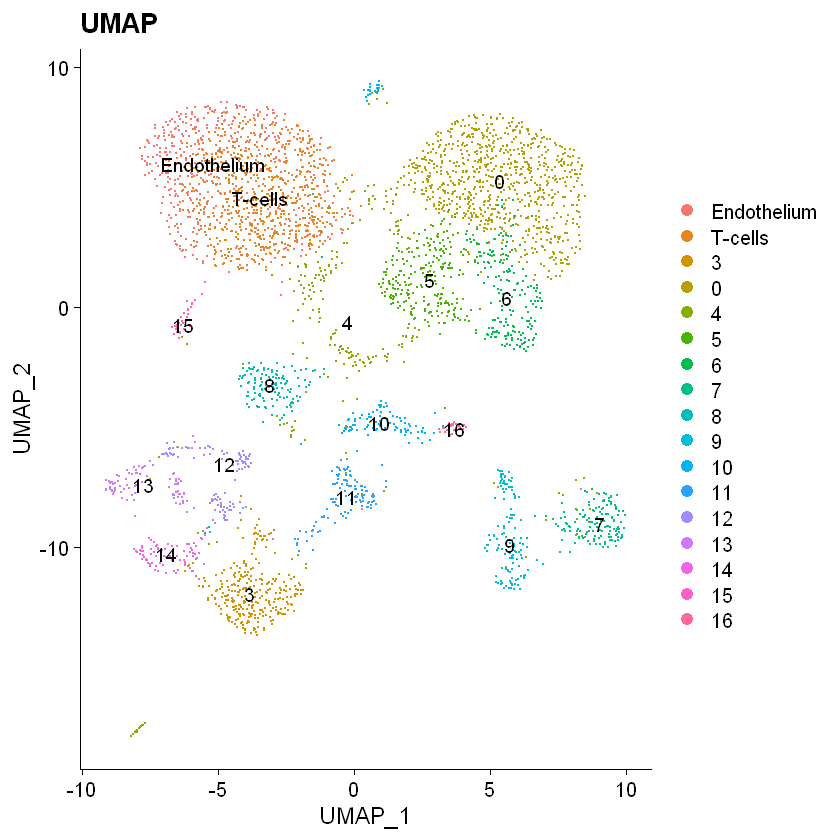

In [69]:
DimPlot(object = input_regressed_renamed_merged, label = TRUE,reduction = "UMAP", pt.size = 0.3) + ggtitle(label = "UMAP")

In [70]:
##FindMarkers function could also find the DEGs from any two groups. test could be non-parametric test or t-test, or negbinom
##min.pct, logfc.threshold
cluster.marker <- FindMarkers(object = input_regressed_renamed_merged,ident.1 =0,ident.2 =3,verbose = FALSE,min.pct=0,logfc.threshold=0)


In [ ]:
head(cluster.marker)